In [1]:
pwd

'C:\\Users\\Baron\\Desktop\\EE_297_Repo\\EE_297\\ML_PATH_EE297\\EE297_env\\01_main\\03_lanes_code'

In [2]:
pwd

'C:\\Users\\Baron\\Desktop\\EE_297_Repo\\EE_297\\ML_PATH_EE297\\EE297_env\\01_main\\03_lanes_code'

In [3]:
pwd

'C:\\Users\\Baron\\Desktop\\EE_297_Repo\\EE_297\\ML_PATH_EE297\\EE297_env\\01_main\\03_lanes_code'

### Source Code Citation: 
https://www.kaggle.com/code/asilpoyrazahin/tusimple-lane-detection

### Loading the dataset

In [4]:
#1. Import Necessary Liobraries
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import cv2
import random
import shutil
from tqdm.auto import tqdm as notebook_tqdm
import tqdm
import tensorflow as tf

import pandas as pd
import numpy as np
from PIL import Image

import os

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt


from keras.models import Sequential
from keras.layers import Input, AveragePooling2D, Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.regularizers import l1

from keras.optimizers import Adam
from sklearn.model_selection import learning_curve
from sklearn.model_selection import StratifiedKFold
from sklearn.utils import shuffle

from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from tensorflow.keras.losses import SparseCategoricalCrossentropy

import seaborn as sns

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

#import torchvision.transforms as transforms

#import warnings
#warnings.filterwarnings("ignore")


In [5]:
IMAGE_FOLDER = r"Z:\EE_297A\dataset\lanes\images"
MASK_FOLDER = r"Z:\EE_297A\dataset\lanes\masks"

In [6]:
def create_dirs_if_not_exist(path):
    if not os.path.exists(path):
        os.makedirs(path)
        print("Directory created:", path)
    else:
        print("Directory already exists:", path)

In [7]:
create_dirs_if_not_exist(IMAGE_FOLDER)
create_dirs_if_not_exist(MASK_FOLDER)

Directory already exists: Z:\EE_297A\dataset\lanes\images
Directory already exists: Z:\EE_297A\dataset\lanes\masks


In [8]:
### Copy Images to  the Directory:
"""
This code is a data pre-processing script that goes through the TuSimple dataset’s
train_set/clips directory and copies only the 20th frame of each video clip into a single
flat folder — typically to simplify training or dataset access.
"""

CLIPS_PATH = r"Z:\EE_297A\dataset\lanes\TUSimple\train_set\clips"

# iterate through each directory
for clip_dir in os.listdir(CLIPS_PATH):
    clip_dir_path = os.path.join(CLIPS_PATH, clip_dir)

    print("Processing Clip:", clip_dir)
    # iterate through each sub directory
    for frame_dir in os.listdir(clip_dir_path):
        frame_path = os.path.join(clip_dir_path, frame_dir, "20.jpg")

        # check if file is present
        if not os.path.isfile(frame_path):
            continue

        # create new filename based on last 2 directory names
        clip_name = os.path.basename(os.path.dirname(frame_path))
        date_name = os.path.basename(os.path.dirname(os.path.dirname(frame_path)))
        new_filename = f"{date_name}_{clip_name}.jpg"
        new_file_path = os.path.join(IMAGE_FOLDER, new_filename)

        # copy the file
        shutil.copy(frame_path, new_file_path)


Processing Clip: 0313-1
Processing Clip: 0313-2
Processing Clip: 0531
Processing Clip: 0601


In [9]:
print("Total images in dataset:", len(os.listdir(IMAGE_FOLDER)))

Total images in dataset: 3626


In [10]:
# load the dataset json files
"""
Code Purpose: Load and combine TuSimple lane label JSONs
lines=True tells pandas each line is a separate JSON object (which is true for TuSimple).
Each line describes a labeled frame's lanes + metadata.
"""

df1_313 = pd.read_json(r"Z:\EE_297A\dataset\lanes\TUSimple\train_set\label_data_0313.json", lines = True)
df2_531 = pd.read_json(r"Z:\EE_297A\dataset\lanes\TUSimple\train_set\label_data_0531.json", lines = True)
df3_601 = pd.read_json(r"Z:\EE_297A\dataset\lanes\TUSimple\train_set\label_data_0601.json", lines = True)

# combine into single dataframe
df_json = pd.concat([df1_313, df2_531, df3_601])
df_json.head()

lanes  \
0  [[-2, -2, -2, -2, 632, 625, 617, 609, 601, 594...   
1  [[-2, -2, -2, 658, 646, 635, 623, 612, 601, 58...   
2  [[-2, 570, 554, 538, 522, 505, 489, 473, 456, ...   
3  [[-2, -2, -2, -2, 555, 542, 530, 517, 505, 493...   
4  [[-2, -2, -2, 522, 525, 528, 531, 534, 537, 53...   

                                           h_samples  \
0  [240, 250, 260, 270, 280, 290, 300, 310, 320, ...   
1  [240, 250, 260, 270, 280, 290, 300, 310, 320, ...   
2  [240, 250, 260, 270, 280, 290, 300, 310, 320, ...   
3  [240, 250, 260, 270, 280, 290, 300, 310, 320, ...   
4  [240, 250, 260, 270, 280, 290, 300, 310, 320, ...   

                    raw_file  
0   clips/0313-1/6040/20.jpg  
1   clips/0313-1/5320/20.jpg  
2  clips/0313-1/23700/20.jpg  
3  clips/0313-1/51660/20.jpg  
4  clips/0313-1/25680/20.jpg

### Creating the Masks
    1. What is a mask?
    Mask: Creating a binary image (also called a segmentation mask) that marks the lane locations pixel-by-pixel.
    2. Creating a binary image (also called a segmentation mask) that marks the lane locations pixel-by-pixel.

In [11]:
# create function for generating masks
def generate_lane_mask(row):
    # create a mask of all zeros
    mask = np.zeros((728, 1280, 1), dtype=np.uint8)

    # extract data from the row
    h_samples = row.h_samples
    lanes = row.lanes
    raw_file = row.raw_file

    # create mask: lane = 1, non-lane = 0
    for lane in lanes:
        # exclude -2 datapoints
        h_samples_filtered = [y for x, y in zip(lane, h_samples) if x != -2]
        lane_filtered = [x for x in lane if x != -2]

        # create array of lane points
        lane_points = np.array(list(zip(lane_filtered, h_samples_filtered)))

        # update lane mask
        cv2.polylines(mask, [lane_points], isClosed = False, color = (255, 255, 255), thickness = 15)
    
    # generate mask filename
    raw_file_path = os.path.normpath(raw_file)  # handles / vs \ properly
    clip_name = os.path.basename(os.path.dirname(raw_file_path))     # e.g., 5160
    date_name = os.path.basename(os.path.dirname(os.path.dirname(raw_file_path)))  # e.g., 0313-1
    mask_filename = f"{date_name}_{clip_name}.jpg"
    mask_filename_path = os.path.join(MASK_FOLDER, mask_filename)

    # write the mask image
    cv2.imwrite(mask_filename_path, mask)

In [12]:
# generate masks
from tqdm import tqdm  #   Ensure this import is present

for index, row in tqdm(df_json.iterrows(), total=len(df_json)):
    generate_lane_mask(row)

100%|█████████████████████████████████████████████████████████████████████████████| 3626/3626 [00:10<00:00, 362.44it/s]


In [13]:
def visualize_image(image_name):
    # get paths
    image_path = os.path.join(IMAGE_FOLDER, image_name)
    mask_path = os.path.join(MASK_FOLDER, image_name)
    
    # read the image and mask
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    mask = cv2.imread(mask_path)
    
    # plot the image
    plt.figure(figsize = (20, 8))
    plt.subplot(1, 2, 1)
    plt.imshow(image)
    plt.title("Road Image")

    plt.subplot(1, 2, 2)
    plt.imshow(mask, cmap="gray")
    plt.title("Ground Truth Mask")
    
    # show the images
    plt.show()

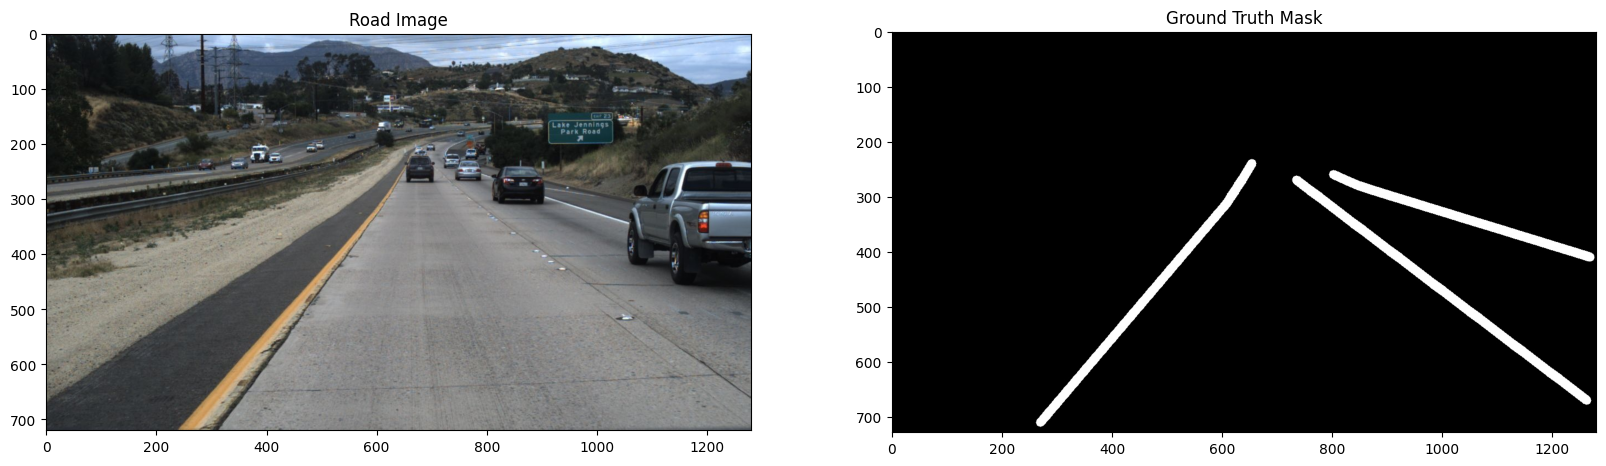

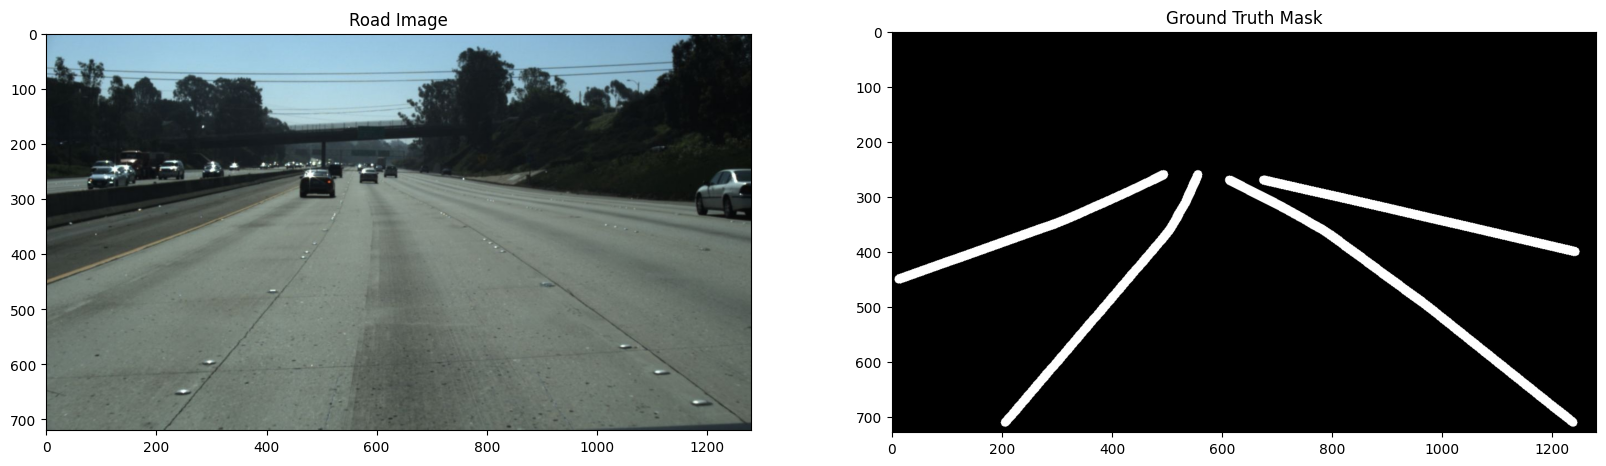

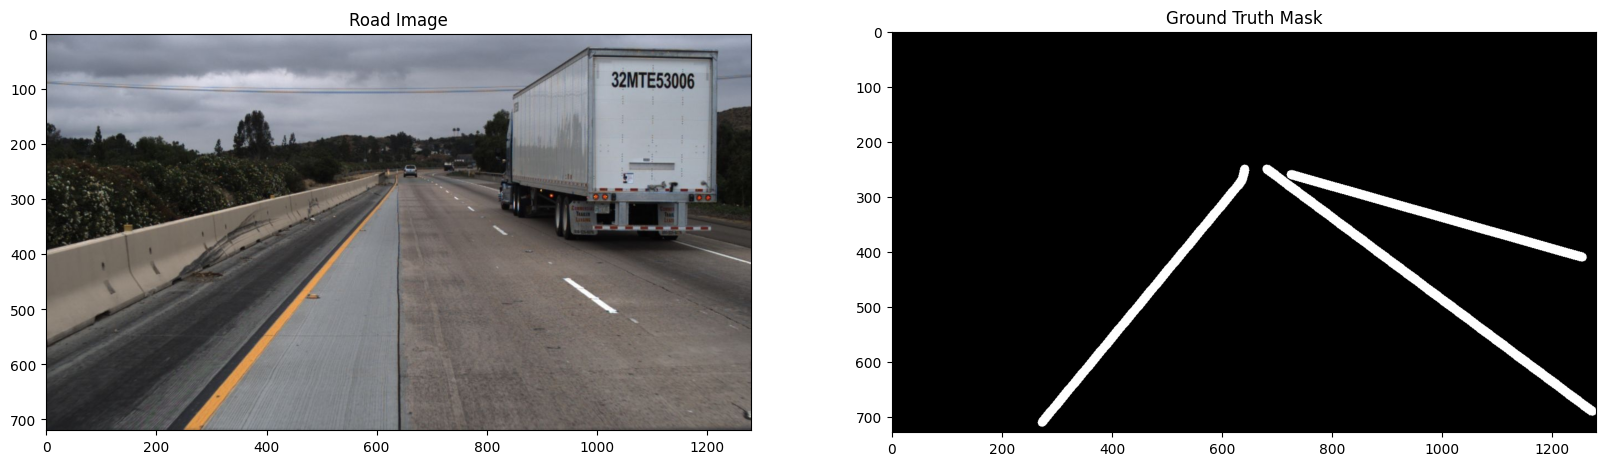

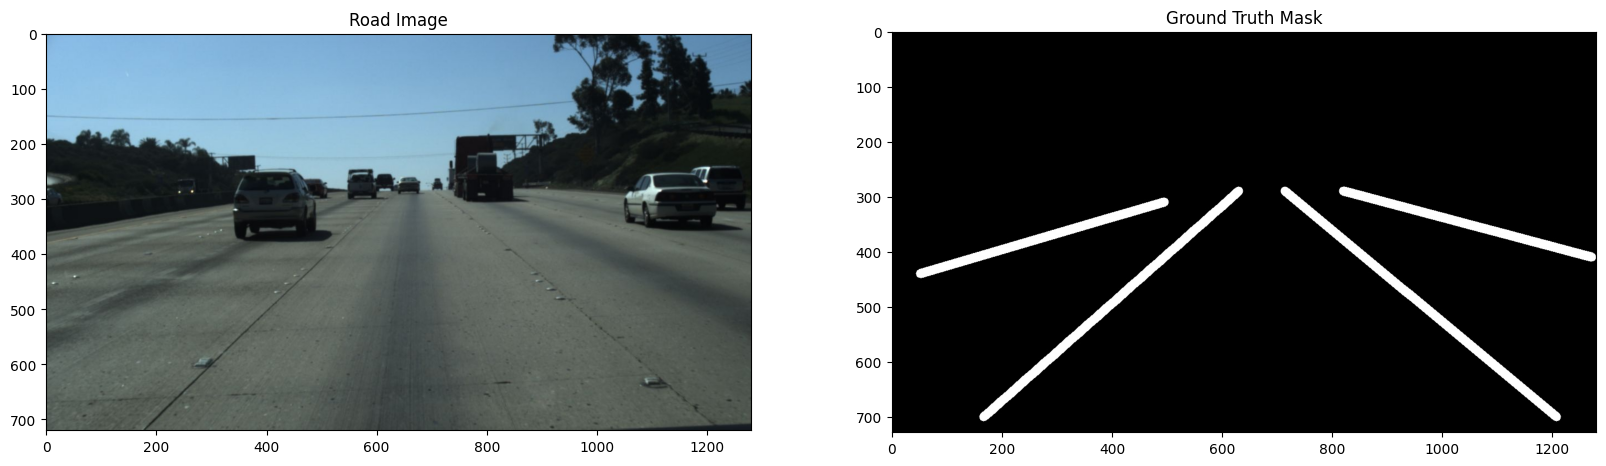

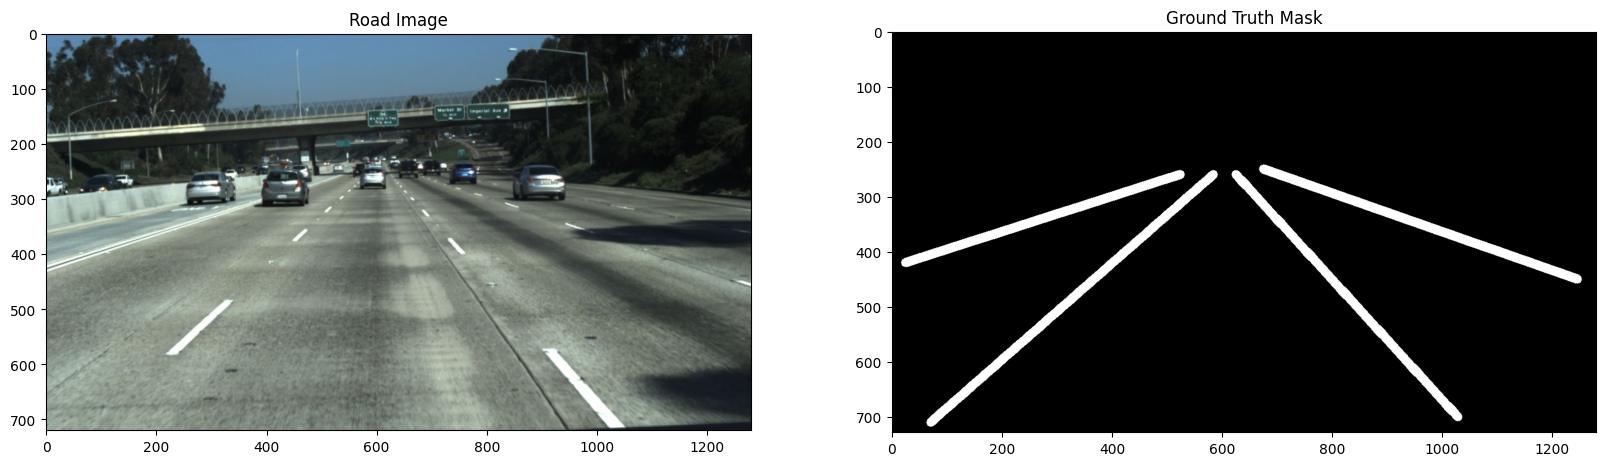

In [14]:
for i in range(5):
    image_name = random.choice(os.listdir(IMAGE_FOLDER))
    visualize_image(image_name)

In [15]:
print("Total masks in dataset:", len(os.listdir(MASK_FOLDER)))

Total masks in dataset: 3626


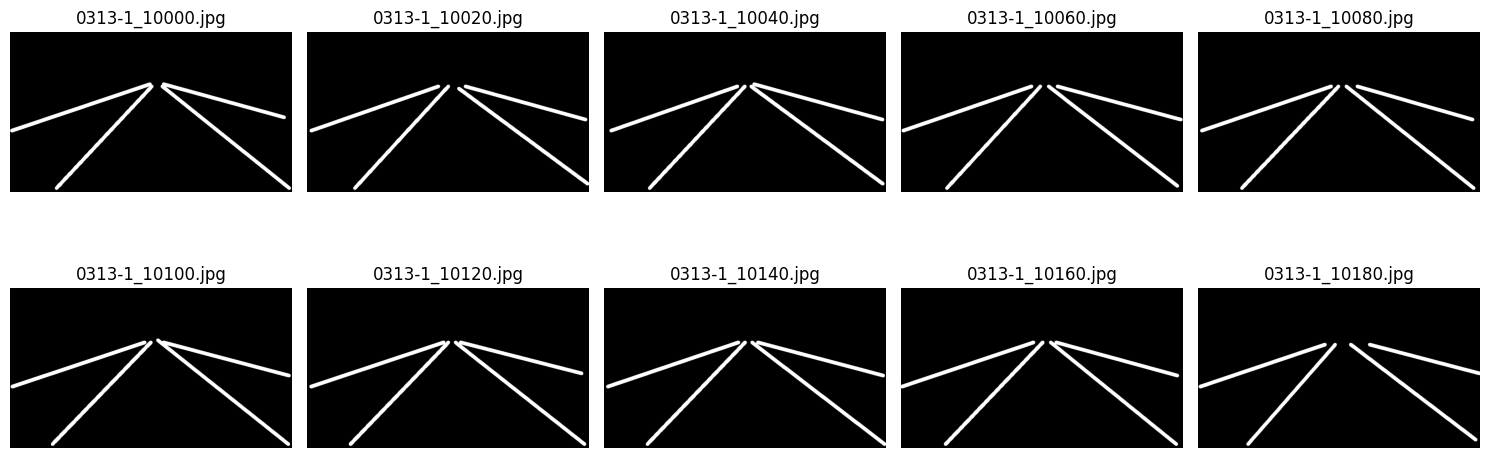

In [16]:
import os
import cv2
import matplotlib.pyplot as plt

# List all mask image files (sorted for consistency)
mask_files = sorted([
    f for f in os.listdir(MASK_FOLDER) if f.endswith(('.png', '.jpg'))
])[:10]

# Plot the first 10 masks
plt.figure(figsize=(15, 6))

for i, mask_file in enumerate(mask_files):
    mask_path = os.path.join(MASK_FOLDER, mask_file)
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

    plt.subplot(2, 5, i+1)
    plt.imshow(mask, cmap='gray')
    plt.title(mask_file)
    plt.axis('off')

plt.tight_layout()
plt.show()

### Training and Testing Splits and Processing
    1. Images
    2. Masks 

In [17]:
lane_train_image_folder = r"Z:\EE_297A\dataset\lanes\train\images"
lane_test_image_folder = r"Z:\EE_297A\dataset\lanes\test\images"
lane_train_mask_folder = r"Z:\EE_297A\dataset\lanes\train\masks"
lane_test_mask_folder = r"Z:\EE_297A\dataset\lanes\test\masks"

In [18]:
for folder_path in [lane_train_image_folder, lane_test_image_folder, lane_train_mask_folder, lane_test_mask_folder]:
    create_dirs_if_not_exist(folder_path)

Directory already exists: Z:\EE_297A\dataset\lanes\train\images
Directory already exists: Z:\EE_297A\dataset\lanes\test\images
Directory already exists: Z:\EE_297A\dataset\lanes\train\masks
Directory already exists: Z:\EE_297A\dataset\lanes\test\masks


In [19]:
from sklearn.model_selection import train_test_split
images = [file for file in os.listdir(IMAGE_FOLDER) if file.endswith(".jpg")]
masks = [file for file in os.listdir(MASK_FOLDER) if file.endswith(".jpg")]

# split for train and test
lane_train_images, lane_val_images = train_test_split(images, test_size=0.1, random_state=42)

### Feature Engineering
    What is feature engineering:
    Feature engineering is the process of creating, transforming, or selecting input variables (features) from raw data in order to improve the performance of a machine learning model.

    1. Image Loading and Preprocessing
    2. Image Sharpening Using a Convolution Kernel
    3. Mask Loading and Normalization
    4.

In [20]:
import tensorflow as tf

def load_image(image_path, mask_path):
    size = [224, 224]

    # 1. Image Loading and Preprocessing
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, size)
    image = image / 255.0  

    # 2. Image Sharpening Using a Convolution Kernel
    kernel = tf.constant([[0., -1., 0.],
                          [-1., 5., -1.],
                          [0., -1., 0.]], dtype=tf.float32)
    kernel = tf.reshape(kernel, [3, 3, 1, 1])

    channels = tf.split(image, num_or_size_splits=3, axis=-1)
    sharpened_channels = []
    for c in channels:
        c_sharp = tf.nn.conv2d(tf.expand_dims(c, axis=0), kernel, strides=1, padding="SAME")
        sharpened_channels.append(tf.squeeze(c_sharp, axis=0))
    image = tf.concat(sharpened_channels, axis=-1)
    image = tf.clip_by_value(image, 0.0, 1.0)  

   # 3. Mask Loading and Normalization
    mask = tf.io.read_file(mask_path)
    mask = tf.image.decode_jpeg(mask, channels=1)
    mask = tf.image.resize(mask, size)
    mask = mask / 255.0  
    
    return image, mask

In [21]:
def dataset_from_folder(image_folder, mask_folder):
    image_files = sorted([os.path.join(image_folder, file) for file in os.listdir(image_folder) if file.endswith(".jpg")])
    mask_files = sorted([os.path.join(mask_folder, file) for file in os.listdir(mask_folder) if file.endswith(".jpg")])

    dataset = tf.data.Dataset.from_tensor_slices((image_files, mask_files))
    dataset = dataset.map(lambda image_path, mask_path: load_image(image_path, mask_path))
    
    return dataset


In [22]:
# load dataset from folder
lane_train_dataset = dataset_from_folder(lane_train_image_folder, lane_train_mask_folder)
lane_test_dataset = dataset_from_folder(lane_test_image_folder, lane_test_mask_folder)

In [23]:
"""
This code is configuring and optimizing TensorFlow tf.data.Dataset pipelines for training and testing.
 Configuration Setup
"""
# set config
BATCH_SIZE = 16
BUFFER_SIZE = 1000

# optimize for performance improvement
lane_train_dataset = lane_train_dataset.cache().shuffle(BUFFER_SIZE).repeat().batch(BATCH_SIZE)
lane_train_dataset = lane_train_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
lane_test_dataset = lane_test_dataset.batch(BATCH_SIZE)
lane_test_datset = lane_test_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

In [24]:
def display_sample(image_list):
    import matplotlib.pyplot as plt
    plt.figure(figsize=(12, 4))

    titles = ["Image", "True Mask", "Predicted Mask"]
    for i in range(len(image_list)):
        plt.subplot(1, len(image_list), i + 1)
        plt.title(titles[i])
        img = tf.clip_by_value(image_list[i], 0, 1)
        plt.imshow(tf.keras.utils.array_to_img(img))
        plt.axis("off")

    plt.tight_layout()
    plt.show()
    plt.close()  #   free up memory

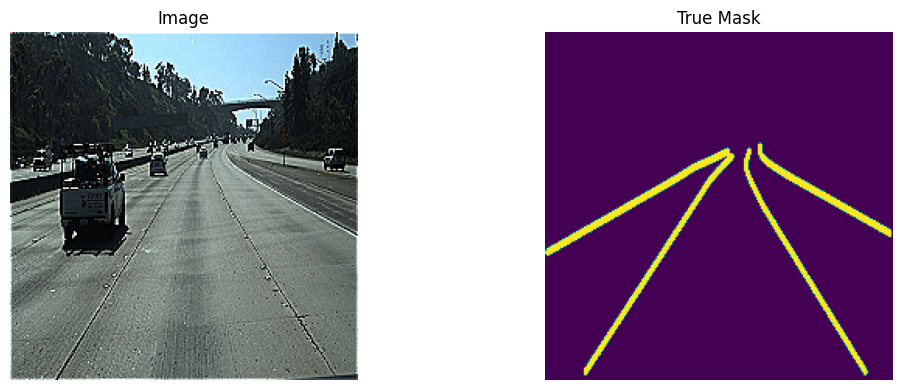

In [25]:
for image, mask in lane_train_dataset.take(1):
    display_sample([image[0], mask[0]])

In [70]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models

class LaneSegOnlyMobileNetV2(nn.Module):
    def __init__(self, pretrained=True, freeze_stem=False):
        super().__init__()
        # ---- Encoder: MobileNetV2 ----
        weights = models.MobileNet_V2_Weights.IMAGENET1K_V1 if pretrained else None
        m = models.mobilenet_v2(weights=weights)

        # Feature extractor (ends at last conv-bn-relu block)
        self.encoder = m.features              # output: (B, 1280, 7, 7) for 224x224
        enc_out_ch = 1280

        if freeze_stem:
            # freeze early, cheap speed/regularization trick
            for p in list(self.encoder.parameters())[:]:
                p.requires_grad = False

        # ---- Lightweight decoder (no skip connections) ----
        self.seg_head = nn.Sequential(
            nn.ConvTranspose2d(enc_out_ch, 256, kernel_size=2, stride=2),  # 7 -> 14
            nn.BatchNorm2d(256), nn.ReLU(inplace=True),

            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256), nn.ReLU(inplace=True),

            nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2),         # 14 -> 28
            nn.BatchNorm2d(128), nn.ReLU(inplace=True),

            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128), nn.ReLU(inplace=True),

            nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2),          # 28 -> 56
            nn.BatchNorm2d(64), nn.ReLU(inplace=True),

            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64), nn.ReLU(inplace=True),

            nn.ConvTranspose2d(64, 32, kernel_size=2, stride=2),           # 56 -> 112
            nn.BatchNorm2d(32), nn.ReLU(inplace=True),

            nn.Conv2d(32, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32), nn.ReLU(inplace=True),

            nn.Conv2d(32, 1, kernel_size=1),  # logits (B,1,112,112)
        )

    def forward(self, x):
        H, W = x.shape[-2:]
        feats = self.encoder(x)                 # (B,1280,7,7) at 224x224
        seg   = self.seg_head(feats)           # (B,1,112,112)
        seg   = F.interpolate(seg, size=(H, W), mode="bilinear", align_corners=False)
        return seg


In [76]:
#model = LaneSegOnly().to(device)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = LaneSegOnlyMobileNetV2(pretrained=True).to(device)

#output_seg = model(torch.randn(4, 3, 224, 224)).to(device)  # batch of 4
#print(output_seg.shape)  # -> (4, 1, 360, 640)

1. Data Preparation
Creates folders for train/test images and masks

Uses train_test_split() to divide image names into 90%/10% train/val

2. TF Dataset Optimization
Adds .cache(), .shuffle(), .repeat(), .batch(), .prefetch() for training dataset

3. Visualization
Defines display_sample(...) to show image + true mask + predicted mask
Calls it on the first sample in lane_train_dataset

4. Model Definition — Switched to PyTorch
You now define MultiTaskNet using PyTorch with:

A ResNet18 encoder

A classification head

A segmentation decoder (upsampling-only, no skip connections)

Final segmentation output is upsampled to (360, 640)


5. Model Output Check
Initializes the model and runs a forward pass on random input

Confirms output shapes:

output_cls.shape → (4, 10)

output_seg.shape → (4, 1, 360, 640)

In [77]:
import os
import cv2
import torch
from torch.utils.data import Dataset

import os
import cv2
import torch
from torch.utils.data import Dataset

class TuSimpleSegDataset(Dataset):
    def __init__(self, images_dir, masks_dir, file_list, transform=None, include_class=False):
        self.images_dir = images_dir
        self.masks_dir = masks_dir
        self.transform = transform
        self.include_class = include_class  # if True, returns (img, 0, mask)

        # Ensure file_list is a list of strings
        self.file_list = [f if isinstance(f, str) else f.item() for f in file_list]

    def __len__(self):
        return len(self.file_list)

    def __getitem__(self, idx):
        fname = self.file_list[idx]
        if isinstance(fname, torch.Tensor):
            fname = fname.tolist()

        # --- Load image ---
        img_path = os.path.join(self.images_dir, fname)
        img = cv2.imread(img_path)
        if img is None:
            raise FileNotFoundError(f"Image not found: {img_path}")
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        # --- Load mask ---
        mask_path = os.path.join(self.masks_dir, fname)
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        if mask is None:
            raise FileNotFoundError(f"Mask not found: {mask_path}")

        # Resize to model output (360x640)
        img  = cv2.resize(img, (224, 224), interpolation=cv2.INTER_LINEAR)       # image
        mask = cv2.resize(mask, (224, 224), interpolation=cv2.INTER_NEAREST) # 640, 360

        # --- Apply transforms (Albumentations-style) ---
        if self.transform:
            augmented = self.transform(image=img, mask=mask)
            img = augmented["image"]
            mask = augmented["mask"]

        # Binarize after transforms to get {0,1} as float
        mask = (mask > 127).astype("float32")

        # --- Convert to tensors ---
        img_tensor = torch.from_numpy(img).permute(2, 0, 1).float() / 255.0   # (3, H, W)
        mask_tensor = torch.from_numpy(mask).unsqueeze(0).float()             # (1, H, W)

        if self.include_class:
            dummy_class = torch.tensor(0, dtype=torch.long)
            return img_tensor, dummy_class, mask_tensor
        else:
            return img_tensor, mask_tensor

In [78]:
train_images_dir = lane_train_image_folder  # Z:\...\train\images
train_masks_dir  = lane_train_mask_folder
val_images_dir   = lane_test_image_folder   # Z:\...\test\images
val_masks_dir    = lane_test_mask_folder

In [79]:
images = [f for f in os.listdir(IMAGE_FOLDER) if f.endswith(".jpg")]
lane_train_images, lane_val_images = train_test_split(images, test_size=0.1, random_state=42)

In [80]:
# Step 2: instantiate datasets
lane_train_dataset = TuSimpleSegDataset(train_images_dir, train_masks_dir, lane_train_images)
lane_val_dataset   = TuSimpleSegDataset(val_images_dir, val_masks_dir, lane_val_images)

In [81]:
from torch.utils.data import DataLoader

lane_train_loader = DataLoader(lane_train_dataset, batch_size=16, shuffle=True)
lane_val_loader   = DataLoader(lane_val_dataset, batch_size=16, shuffle=False)


In [82]:
mask_dir = r"Z:\EE_297A\dataset\lanes\train\masks"

# List all .png files
png_files = [f for f in os.listdir(mask_dir) if f.endswith(".png")]

# Print results
if png_files:
    print(f"Found {len(png_files)} .png files in the mask folder:")
    print(png_files[:5])  # show just a few
else:
    print(" No .png files found in the mask folder.")

 No .png files found in the mask folder.


In [83]:

images_dir = r"Z:\EE_297A\dataset\lanes\train\images"  # Adjust if needed
image_filenames = os.listdir(images_dir)

# Find any .png files in the image folder
png_images = [f for f in image_filenames if f.lower().endswith(".png")]

if png_images:
    print(f"❗ Found {len(png_images)} PNG files in image folder:")
    print(png_images[:5])  # Show first few
else:
    print(" No PNG files found in the image folder.")

 No PNG files found in the image folder.


In [84]:
# Print Python version
import sys
sys.version

'3.8.20 (default, Oct  3 2024, 15:19:54) [MSC v.1929 64 bit (AMD64)]'

In [85]:
import torch
print("PyTorch version:", torch.__version__)

PyTorch version: 2.4.1


In [86]:
# Check GPU availability
cuda_available = torch.cuda.is_available()
print("CUDA available:", cuda_available)

CUDA available: True


In [87]:
if cuda_available:
    print("CUDA version (PyTorch built with):", torch.version.cuda)
    print("cuDNN version:", torch.backends.cudnn.version())
    print("Number of CUDA devices:", torch.cuda.device_count())

    for i in range(torch.cuda.device_count()):
        print(f"\n[GPU {i}]")
        print("Device Name:", torch.cuda.get_device_name(i))
        print("Device Capability:", torch.cuda.get_device_capability(i))
        print("Total Memory (MB):", round(torch.cuda.get_device_properties(i).total_memory / 1024**2, 2))
        print("Allocated Memory (MB):", round(torch.cuda.memory_allocated(i) / 1024**2, 2))
        print("Cached Memory (MB):", round(torch.cuda.memory_reserved(i) / 1024**2, 2))
else:
    print("⚠️ No CUDA-compatible GPU detected.")

CUDA version (PyTorch built with): 12.1
cuDNN version: 90100
Number of CUDA devices: 1

[GPU 0]
Device Name: NVIDIA GeForce RTX 3060 Ti
Device Capability: (8, 6)
Total Memory (MB): 8191.38
Allocated Memory (MB): 674.72
Cached Memory (MB): 14550.0


In [88]:
# === Setup ===
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

### Training Model: Only Rerun When ready

### Training Model: Only Rerun When ready

### Training Model: Only Rerun When ready

In [102]:
import torch
import torch.nn.functional as F

from tqdm import tqdm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

criterion_seg = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

scaler = torch.amp.GradScaler(device.type)   # ✅ new API
torch.backends.cudnn.benchmark = True

EPOCHS = 50

for epoch in range(EPOCHS):
    # ---------------- TRAIN ----------------
    model.train()
    train_loss = 0.0
    print(f"\nEpoch {epoch+1}/{EPOCHS}")

    for images, masks in tqdm(lane_train_loader, desc="Train", leave=True):
        images = images.to(device, non_blocking=True)
        masks  = masks.to(device, non_blocking=True).float()

        optimizer.zero_grad(set_to_none=True)

        with torch.amp.autocast(device.type):   # ✅ new API
            out_seg = model(images)
            if out_seg.shape[-2:] != masks.shape[-2:]:
                out_seg = F.interpolate(out_seg, size=masks.shape[-2:], mode="bilinear", align_corners=False)
            loss = criterion_seg(out_seg, masks)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        train_loss += loss.item()

    avg_train_loss = train_loss / len(lane_train_loader)
    print(f"Train Loss: {avg_train_loss:.4f}")

    # ---------------- VALIDATION ----------------
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for images, masks in tqdm(lane_val_loader, desc="Val", leave=True):
            images = images.to(device, non_blocking=True)
            masks  = masks.to(device, non_blocking=True).float()

            with torch.amp.autocast(device.type):
                out_seg = model(images)
                if out_seg.shape[-2:] != masks.shape[-2:]:
                    out_seg = F.interpolate(out_seg, size=masks.shape[-2:], mode="bilinear", align_corners=False)
                loss = criterion_seg(out_seg, masks)

            val_loss += loss.item()

    avg_val_loss = val_loss / len(lane_val_loader)
    print(f"Val Loss: {avg_val_loss:.4f}")


Epoch 1/50


Train: 100%|█████████████████████████████████████████████████████████████████████████| 204/204 [01:30<00:00,  2.25it/s]


Train Loss: 0.0444


Val: 100%|█████████████████████████████████████████████████████████████████████████████| 23/23 [00:09<00:00,  2.45it/s]


Val Loss: 0.0512

Epoch 2/50


Train: 100%|█████████████████████████████████████████████████████████████████████████| 204/204 [00:43<00:00,  4.65it/s]


Train Loss: 0.0412


Val: 100%|█████████████████████████████████████████████████████████████████████████████| 23/23 [00:03<00:00,  5.76it/s]


Val Loss: 0.0494

Epoch 3/50


Train: 100%|█████████████████████████████████████████████████████████████████████████| 204/204 [00:44<00:00,  4.63it/s]


Train Loss: 0.0393


Val: 100%|█████████████████████████████████████████████████████████████████████████████| 23/23 [00:04<00:00,  5.66it/s]


Val Loss: 0.0488

Epoch 4/50


Train: 100%|█████████████████████████████████████████████████████████████████████████| 204/204 [00:44<00:00,  4.60it/s]


Train Loss: 0.0382


Val: 100%|█████████████████████████████████████████████████████████████████████████████| 23/23 [00:04<00:00,  5.68it/s]


Val Loss: 0.0497

Epoch 5/50


Train: 100%|█████████████████████████████████████████████████████████████████████████| 204/204 [00:44<00:00,  4.58it/s]


Train Loss: 0.0366


Val: 100%|█████████████████████████████████████████████████████████████████████████████| 23/23 [00:04<00:00,  5.70it/s]


Val Loss: 0.0491

Epoch 6/50


Train: 100%|█████████████████████████████████████████████████████████████████████████| 204/204 [00:44<00:00,  4.63it/s]


Train Loss: 0.0358


Val: 100%|█████████████████████████████████████████████████████████████████████████████| 23/23 [00:04<00:00,  5.72it/s]


Val Loss: 0.0517

Epoch 7/50


Train: 100%|█████████████████████████████████████████████████████████████████████████| 204/204 [00:44<00:00,  4.54it/s]


Train Loss: 0.0346


Val: 100%|█████████████████████████████████████████████████████████████████████████████| 23/23 [00:04<00:00,  5.75it/s]


Val Loss: 0.0497

Epoch 8/50


Train: 100%|█████████████████████████████████████████████████████████████████████████| 204/204 [00:44<00:00,  4.57it/s]


Train Loss: 0.0338


Val: 100%|█████████████████████████████████████████████████████████████████████████████| 23/23 [00:03<00:00,  5.75it/s]


Val Loss: 0.0538

Epoch 9/50


Train: 100%|█████████████████████████████████████████████████████████████████████████| 204/204 [00:44<00:00,  4.59it/s]


Train Loss: 0.0328


Val: 100%|█████████████████████████████████████████████████████████████████████████████| 23/23 [00:04<00:00,  5.59it/s]


Val Loss: 0.0512

Epoch 10/50


Train: 100%|█████████████████████████████████████████████████████████████████████████| 204/204 [00:44<00:00,  4.57it/s]


Train Loss: 0.0316


Val: 100%|█████████████████████████████████████████████████████████████████████████████| 23/23 [00:03<00:00,  5.81it/s]


Val Loss: 0.0515

Epoch 11/50


Train: 100%|█████████████████████████████████████████████████████████████████████████| 204/204 [00:44<00:00,  4.61it/s]


Train Loss: 0.0315


Val: 100%|█████████████████████████████████████████████████████████████████████████████| 23/23 [00:04<00:00,  5.63it/s]


Val Loss: 0.0501

Epoch 12/50


Train: 100%|█████████████████████████████████████████████████████████████████████████| 204/204 [00:44<00:00,  4.59it/s]


Train Loss: 0.0305


Val: 100%|█████████████████████████████████████████████████████████████████████████████| 23/23 [00:03<00:00,  5.80it/s]


Val Loss: 0.0519

Epoch 13/50


Train: 100%|█████████████████████████████████████████████████████████████████████████| 204/204 [00:44<00:00,  4.59it/s]


Train Loss: 0.0301


Val: 100%|█████████████████████████████████████████████████████████████████████████████| 23/23 [00:04<00:00,  5.69it/s]


Val Loss: 0.0535

Epoch 14/50


Train: 100%|█████████████████████████████████████████████████████████████████████████| 204/204 [00:44<00:00,  4.56it/s]


Train Loss: 0.0296


Val: 100%|█████████████████████████████████████████████████████████████████████████████| 23/23 [00:04<00:00,  5.48it/s]


Val Loss: 0.0533

Epoch 15/50


Train: 100%|█████████████████████████████████████████████████████████████████████████| 204/204 [00:44<00:00,  4.60it/s]


Train Loss: 0.0282


Val: 100%|█████████████████████████████████████████████████████████████████████████████| 23/23 [00:04<00:00,  5.61it/s]


Val Loss: 0.0537

Epoch 16/50


Train: 100%|█████████████████████████████████████████████████████████████████████████| 204/204 [00:43<00:00,  4.65it/s]


Train Loss: 0.0281


Val: 100%|█████████████████████████████████████████████████████████████████████████████| 23/23 [00:03<00:00,  5.88it/s]


Val Loss: 0.0540

Epoch 17/50


Train: 100%|█████████████████████████████████████████████████████████████████████████| 204/204 [00:44<00:00,  4.56it/s]


Train Loss: 0.0276


Val: 100%|█████████████████████████████████████████████████████████████████████████████| 23/23 [00:04<00:00,  5.12it/s]


Val Loss: 0.0581

Epoch 18/50


Train: 100%|█████████████████████████████████████████████████████████████████████████| 204/204 [00:45<00:00,  4.52it/s]


Train Loss: 0.0273


Val: 100%|█████████████████████████████████████████████████████████████████████████████| 23/23 [00:03<00:00,  5.85it/s]


Val Loss: 0.0543

Epoch 19/50


Train: 100%|█████████████████████████████████████████████████████████████████████████| 204/204 [00:43<00:00,  4.66it/s]


Train Loss: 0.0264


Val: 100%|█████████████████████████████████████████████████████████████████████████████| 23/23 [00:03<00:00,  6.00it/s]


Val Loss: 0.0548

Epoch 20/50


Train: 100%|█████████████████████████████████████████████████████████████████████████| 204/204 [00:42<00:00,  4.82it/s]


Train Loss: 0.0262


Val: 100%|█████████████████████████████████████████████████████████████████████████████| 23/23 [00:03<00:00,  6.08it/s]


Val Loss: 0.0548

Epoch 21/50


Train: 100%|█████████████████████████████████████████████████████████████████████████| 204/204 [00:42<00:00,  4.86it/s]


Train Loss: 0.0260


Val: 100%|█████████████████████████████████████████████████████████████████████████████| 23/23 [00:03<00:00,  6.20it/s]


Val Loss: 0.0568

Epoch 22/50


Train: 100%|█████████████████████████████████████████████████████████████████████████| 204/204 [00:42<00:00,  4.74it/s]


Train Loss: 0.0252


Val: 100%|█████████████████████████████████████████████████████████████████████████████| 23/23 [00:04<00:00,  5.70it/s]


Val Loss: 0.0565

Epoch 23/50


Train: 100%|█████████████████████████████████████████████████████████████████████████| 204/204 [00:44<00:00,  4.57it/s]


Train Loss: 0.0252


Val: 100%|█████████████████████████████████████████████████████████████████████████████| 23/23 [00:04<00:00,  5.38it/s]


Val Loss: 0.0544

Epoch 24/50


Train: 100%|█████████████████████████████████████████████████████████████████████████| 204/204 [00:44<00:00,  4.59it/s]


Train Loss: 0.0248


Val: 100%|█████████████████████████████████████████████████████████████████████████████| 23/23 [00:04<00:00,  5.64it/s]


Val Loss: 0.0566

Epoch 25/50


Train: 100%|█████████████████████████████████████████████████████████████████████████| 204/204 [00:46<00:00,  4.43it/s]


Train Loss: 0.0247


Val: 100%|█████████████████████████████████████████████████████████████████████████████| 23/23 [00:04<00:00,  5.20it/s]


Val Loss: 0.0587

Epoch 26/50


Train: 100%|█████████████████████████████████████████████████████████████████████████| 204/204 [00:43<00:00,  4.66it/s]


Train Loss: 0.0239


Val: 100%|█████████████████████████████████████████████████████████████████████████████| 23/23 [00:04<00:00,  5.63it/s]


Val Loss: 0.0552

Epoch 27/50


Train: 100%|█████████████████████████████████████████████████████████████████████████| 204/204 [00:44<00:00,  4.57it/s]


Train Loss: 0.0235


Val: 100%|█████████████████████████████████████████████████████████████████████████████| 23/23 [00:04<00:00,  5.61it/s]


Val Loss: 0.0568

Epoch 28/50


Train: 100%|█████████████████████████████████████████████████████████████████████████| 204/204 [00:44<00:00,  4.60it/s]


Train Loss: 0.0233


Val: 100%|█████████████████████████████████████████████████████████████████████████████| 23/23 [00:04<00:00,  5.32it/s]


Val Loss: 0.0568

Epoch 29/50


Train: 100%|█████████████████████████████████████████████████████████████████████████| 204/204 [00:43<00:00,  4.66it/s]


Train Loss: 0.0226


Val: 100%|█████████████████████████████████████████████████████████████████████████████| 23/23 [00:03<00:00,  5.93it/s]


Val Loss: 0.0594

Epoch 30/50


Train: 100%|█████████████████████████████████████████████████████████████████████████| 204/204 [00:42<00:00,  4.76it/s]


Train Loss: 0.0228


Val: 100%|█████████████████████████████████████████████████████████████████████████████| 23/23 [00:03<00:00,  5.96it/s]


Val Loss: 0.0591

Epoch 31/50


Train: 100%|█████████████████████████████████████████████████████████████████████████| 204/204 [00:43<00:00,  4.70it/s]


Train Loss: 0.0222


Val: 100%|█████████████████████████████████████████████████████████████████████████████| 23/23 [00:03<00:00,  6.01it/s]


Val Loss: 0.0612

Epoch 32/50


Train: 100%|█████████████████████████████████████████████████████████████████████████| 204/204 [00:43<00:00,  4.68it/s]


Train Loss: 0.0221


Val: 100%|█████████████████████████████████████████████████████████████████████████████| 23/23 [00:03<00:00,  5.96it/s]


Val Loss: 0.0601

Epoch 33/50


Train: 100%|█████████████████████████████████████████████████████████████████████████| 204/204 [00:43<00:00,  4.68it/s]


Train Loss: 0.0221


Val: 100%|█████████████████████████████████████████████████████████████████████████████| 23/23 [00:03<00:00,  5.89it/s]


Val Loss: 0.0586

Epoch 34/50


Train: 100%|█████████████████████████████████████████████████████████████████████████| 204/204 [00:43<00:00,  4.70it/s]


Train Loss: 0.0220


Val: 100%|█████████████████████████████████████████████████████████████████████████████| 23/23 [00:03<00:00,  5.90it/s]


Val Loss: 0.0584

Epoch 35/50


Train: 100%|█████████████████████████████████████████████████████████████████████████| 204/204 [00:46<00:00,  4.42it/s]


Train Loss: 0.0215


Val: 100%|█████████████████████████████████████████████████████████████████████████████| 23/23 [00:04<00:00,  5.34it/s]


Val Loss: 0.0604

Epoch 36/50


Train: 100%|█████████████████████████████████████████████████████████████████████████| 204/204 [00:46<00:00,  4.41it/s]


Train Loss: 0.0211


Val: 100%|█████████████████████████████████████████████████████████████████████████████| 23/23 [00:04<00:00,  5.50it/s]


Val Loss: 0.0611

Epoch 37/50


Train: 100%|█████████████████████████████████████████████████████████████████████████| 204/204 [00:47<00:00,  4.33it/s]


Train Loss: 0.0205


Val: 100%|█████████████████████████████████████████████████████████████████████████████| 23/23 [00:04<00:00,  5.53it/s]


Val Loss: 0.0620

Epoch 38/50


Train: 100%|█████████████████████████████████████████████████████████████████████████| 204/204 [00:48<00:00,  4.17it/s]


Train Loss: 0.0206


Val: 100%|█████████████████████████████████████████████████████████████████████████████| 23/23 [00:04<00:00,  4.91it/s]


Val Loss: 0.0615

Epoch 39/50


Train: 100%|█████████████████████████████████████████████████████████████████████████| 204/204 [00:47<00:00,  4.31it/s]


Train Loss: 0.0209


Val: 100%|█████████████████████████████████████████████████████████████████████████████| 23/23 [00:04<00:00,  5.30it/s]


Val Loss: 0.0618

Epoch 40/50


Train: 100%|█████████████████████████████████████████████████████████████████████████| 204/204 [00:46<00:00,  4.37it/s]


Train Loss: 0.0203


Val: 100%|█████████████████████████████████████████████████████████████████████████████| 23/23 [00:04<00:00,  5.38it/s]


Val Loss: 0.0625

Epoch 41/50


Train: 100%|█████████████████████████████████████████████████████████████████████████| 204/204 [00:47<00:00,  4.34it/s]


Train Loss: 0.0202


Val: 100%|█████████████████████████████████████████████████████████████████████████████| 23/23 [00:04<00:00,  5.35it/s]


Val Loss: 0.0646

Epoch 42/50


Train: 100%|█████████████████████████████████████████████████████████████████████████| 204/204 [00:47<00:00,  4.28it/s]


Train Loss: 0.0203


Val: 100%|█████████████████████████████████████████████████████████████████████████████| 23/23 [00:04<00:00,  5.22it/s]


Val Loss: 0.0609

Epoch 43/50


Train: 100%|█████████████████████████████████████████████████████████████████████████| 204/204 [00:48<00:00,  4.23it/s]


Train Loss: 0.0203


Val: 100%|█████████████████████████████████████████████████████████████████████████████| 23/23 [00:04<00:00,  5.30it/s]


Val Loss: 0.0643

Epoch 44/50


Train: 100%|█████████████████████████████████████████████████████████████████████████| 204/204 [00:47<00:00,  4.29it/s]


Train Loss: 0.0197


Val: 100%|█████████████████████████████████████████████████████████████████████████████| 23/23 [00:04<00:00,  5.42it/s]


Val Loss: 0.0630

Epoch 45/50


Train: 100%|█████████████████████████████████████████████████████████████████████████| 204/204 [00:47<00:00,  4.27it/s]


Train Loss: 0.0195


Val: 100%|█████████████████████████████████████████████████████████████████████████████| 23/23 [00:04<00:00,  5.40it/s]


Val Loss: 0.0651

Epoch 46/50


Train: 100%|█████████████████████████████████████████████████████████████████████████| 204/204 [00:48<00:00,  4.22it/s]


Train Loss: 0.0193


Val: 100%|█████████████████████████████████████████████████████████████████████████████| 23/23 [00:04<00:00,  5.25it/s]


Val Loss: 0.0647

Epoch 47/50


Train: 100%|█████████████████████████████████████████████████████████████████████████| 204/204 [00:47<00:00,  4.29it/s]


Train Loss: 0.0193


Val: 100%|█████████████████████████████████████████████████████████████████████████████| 23/23 [00:04<00:00,  5.31it/s]


Val Loss: 0.0640

Epoch 48/50


Train: 100%|█████████████████████████████████████████████████████████████████████████| 204/204 [00:47<00:00,  4.29it/s]


Train Loss: 0.0189


Val: 100%|█████████████████████████████████████████████████████████████████████████████| 23/23 [00:04<00:00,  5.39it/s]


Val Loss: 0.0640

Epoch 49/50


Train: 100%|█████████████████████████████████████████████████████████████████████████| 204/204 [00:47<00:00,  4.30it/s]


Train Loss: 0.0189


Val: 100%|█████████████████████████████████████████████████████████████████████████████| 23/23 [00:04<00:00,  5.37it/s]


Val Loss: 0.0671

Epoch 50/50


Train: 100%|█████████████████████████████████████████████████████████████████████████| 204/204 [00:47<00:00,  4.28it/s]


Train Loss: 0.0186


Val: 100%|█████████████████████████████████████████████████████████████████████████████| 23/23 [00:04<00:00,  5.34it/s]

Val Loss: 0.0682


In [103]:
# === Save model weights ===
torch.save(model.state_dict(), "lane_seg_weights.pth")
print(" Model weights saved to lane_seg_weights.pth")

 Model weights saved to lane_seg_weights.pth


### Loading Pretrained Model

In [104]:
model = LaneSegOnlyMobileNetV2()
model.load_state_dict(torch.load("lane_seg_weights.pth"))
model.to(device)
model.eval()  # set to inference mode

C:\Users\Baron\AppData\Local\Temp\ipykernel_2188\1183639246.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("lane_seg_weights.pth"))


LaneSegOnlyMobileNetV2(
  (encoder): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2

In [105]:
# Define test folders (if not already defined)
test_images_dir = lane_test_image_folder
test_masks_dir  = lane_test_mask_folder

# Get test image filenames
test_images = [f for f in os.listdir(test_images_dir) if f.endswith(".jpg")]

# Create the dataset
lane_test_dataset = TuSimpleSegDataset(test_images_dir, test_masks_dir, test_images)

#   Wrap in DataLoader
from torch.utils.data import DataLoader

lane_test_loader = DataLoader(lane_test_dataset, batch_size=16, shuffle=False)

In [106]:
import torch
import torch.nn as nn
from tqdm import tqdm

# === Loss Function (segmentation only) ===
criterion_seg = nn.BCEWithLogitsLoss()

# === Metric: Dice Coefficient ===
def dice_coefficient(y_true, y_pred, threshold=0.5, eps=1e-7):
    # y_pred: raw logits -> sigmoid -> threshold -> {0,1}
    y_pred = torch.sigmoid(y_pred)
    y_pred = (y_pred > threshold).float()
    y_true = y_true.float()

    intersection = (y_pred * y_true).sum(dim=(1, 2, 3))
    union = y_pred.sum(dim=(1, 2, 3)) + y_true.sum(dim=(1, 2, 3))
    dice = (2.0 * intersection + eps) / (union + eps)
    return dice.mean()

# === Test Loop (segmentation only) ===
test_loss = 0.0
dice_total = 0.0
model.eval()

with torch.no_grad():
    for batch in tqdm(lane_test_loader):
        # Support both (images, masks) and (images, class_labels, masks)
        if len(batch) == 3:
            images, _, masks = batch
        else:
            images, masks = batch

        images = images.to(device, non_blocking=True)
        masks = masks.to(device, non_blocking=True).float()  # BCEWithLogitsLoss expects float

        out_seg = model(images)  # LaneSegOnly returns logits for the mask

        loss = criterion_seg(out_seg, masks)
        test_loss += loss.item()

        dice = dice_coefficient(masks, out_seg)
        dice_total += dice.item()

avg_test_loss = test_loss / len(lane_test_loader)
avg_dice_score = dice_total / len(lane_test_loader)

print("\n🧪 Test Results:")
print(f"Test Loss: {avg_test_loss:.4f}")
print(f"Dice Score: {avg_dice_score:.4f}")


100%|██████████████████████████████████████████████████████████████████████████████████| 23/23 [00:04<00:00,  5.38it/s]


🧪 Test Results:
Test Loss: 0.0682
Dice Score: 0.7662


In [107]:
import matplotlib.pyplot as plt
import torch

def show_sample_prediction(model, dataset, device, index=0):
    model.eval()

    # --- Get sample from dataset ---
    sample = dataset[index]
    if len(sample) == 3:
        image, _, true_mask = sample   # if dataset returns (image, dummy_class, mask)
    else:
        image, true_mask = sample      # if dataset returns (image, mask)

    image_tensor = image.unsqueeze(0).to(device)  # Add batch dimension

    with torch.no_grad():
        pred_mask = model(image_tensor)           # LaneSegOnly → logits
        pred_mask = torch.sigmoid(pred_mask)      # Convert to probabilities
        pred_mask = (pred_mask > 0.5).float()     # Threshold at 0.5

    # --- Convert to numpy for visualization ---
    img_np = image.permute(1, 2, 0).cpu().numpy()  # (C,H,W) → (H,W,C)
    true_np = true_mask.squeeze().cpu().numpy()
    pred_np = pred_mask.squeeze().cpu().numpy()

    # --- Plot ---
    plt.figure(figsize=(12, 4))
    titles = ["Input Image", "Ground Truth Mask", "Predicted Mask"]
    for i, img in enumerate([img_np, true_np, pred_np]):
        plt.subplot(1, 3, i + 1)
        plt.imshow(img, cmap="gray" if i > 0 else None)
        plt.title(titles[i])
        plt.axis("off")
    plt.tight_layout()
    plt.show()


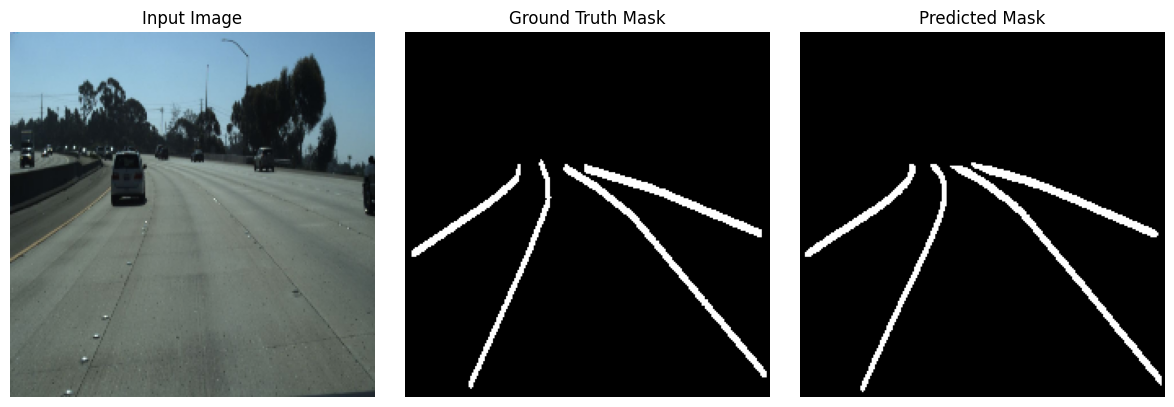

In [108]:
# Example: show first test image prediction
show_sample_prediction(model, lane_test_dataset, device, index=20)

In [109]:
import matplotlib.pyplot as plt
import torch
import numpy as np
import cv2

def show_sample_prediction_overlay(model, dataset, device, index=0, alpha=0.4, color=(1, 0, 0)):
    model.eval()
    
    # --- Get sample from dataset ---
    sample = dataset[index]
    if len(sample) == 3:
        image, _, true_mask = sample   # dataset returns (image, dummy_class, mask)
    else:
        image, true_mask = sample      # dataset returns (image, mask)

    image_tensor = image.unsqueeze(0).to(device)  # (1, 3, H, W)

    with torch.no_grad():
        pred_mask = model(image_tensor)           # LaneSegOnly → logits
        pred_mask = torch.sigmoid(pred_mask)      # → probabilities
        pred_mask = (pred_mask > 0.5).float()     # → binary mask

    # --- Convert tensors to numpy ---
    img_np = image.permute(1, 2, 0).cpu().numpy()  # (H, W, 3)
    pred_np = pred_mask.squeeze().cpu().numpy()    # (H', W')

    # 🔧 Resize pred mask to match original image size
    pred_np = cv2.resize(pred_np, (img_np.shape[1], img_np.shape[0]), interpolation=cv2.INTER_NEAREST)

    # Normalize image to [0, 1] for display
    if img_np.max() > 1.0:
        img_np = img_np / 255.0

    # --- Create color overlay ---
    overlay = np.zeros_like(img_np)
    overlay[:, :, 0] = color[0]  # R
    overlay[:, :, 1] = color[1]  # G
    overlay[:, :, 2] = color[2]  # B

    # --- Apply overlay to predicted mask regions ---
    blended = img_np.copy()
    blended[pred_np == 1] = (1 - alpha) * blended[pred_np == 1] + alpha * overlay[pred_np == 1]

    # --- Plot ---
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(img_np)
    plt.title("Input Image")
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.imshow(blended)
    plt.title("Overlay: Predicted Mask")
    plt.axis("off")

    plt.tight_layout()
    plt.show()


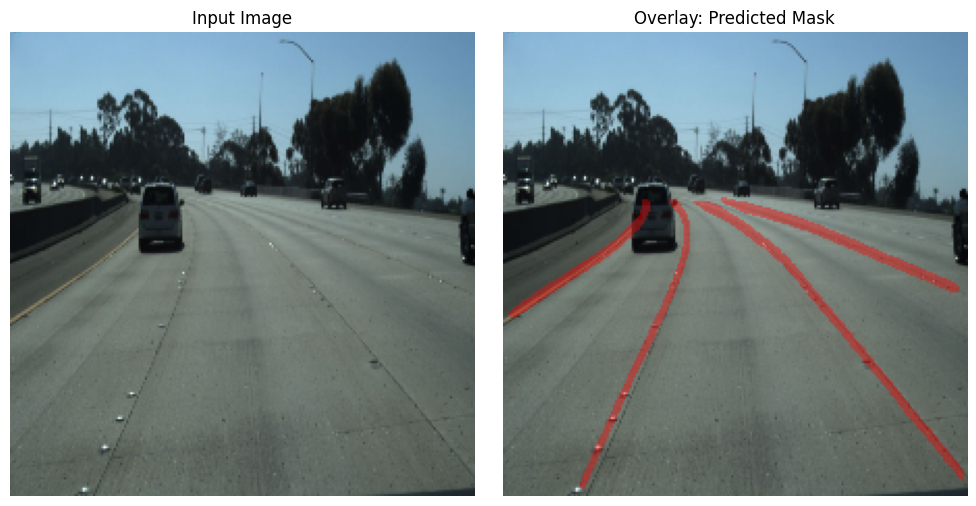

In [110]:
show_sample_prediction_overlay(model, lane_test_dataset, device, index=20, alpha=0.4)

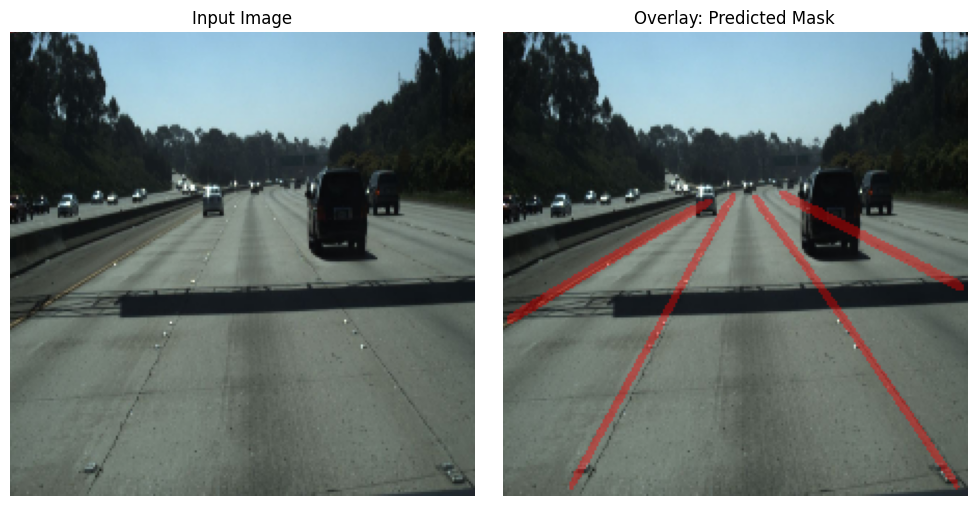

In [111]:
show_sample_prediction_overlay(model, lane_test_dataset, device, index=1, alpha=0.4)